In [1]:
from pyspark.sql import SparkSession
import sys

# Get Spark context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1716668527664_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%configure -f
{
    "conf": {
        "spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.1",
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1716668527664_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1716668527664_0003,pyspark,idle,Link,Link,✔


In [117]:
# sc.install_pypi_package('Cython==0.29.24', "https://pypi.org/simple")
# sc.install_pypi_package('pybind11', "https://pypi.org/simple")

# sc.install_pypi_package('numpy==1.21.6', "https://pypi.org/simple")
# sc.install_pypi_package('scipy', "https://pypi.org/simple")
# sc.install_pypi_package('pillow', "https://pypi.org/simple")
# sc.install_pypi_package('scikit-learn', "https://pypi.org/simple")
# sc.install_pypi_package('sentence-transformers', "https://pypi.org/simple")


# sc.install_pypi_package("pandas==1.0.5","https://pypi.org/simple")
# sc.install_pypi_package("scipy==1.4.1","https://pypi.org/simple")
sc.install_pypi_package("matplotlib==3.2.1","https://pypi.org/simple")
# sc.install_pypi_package('spark-nlp',"https://pypi.org/simple")
# sc.install_pypi_package('spark-sklearn',"https://pypi.org/simple")



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/9d/ea/6d76df31432a0e6fdf81681a895f009a4bb47b3c39036db3e1b528191d52/pyparsing-3.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f9/77/e3046bf19720b22e3e0b7c12e28f6f2c0c18a213fb91a56cea640862270f/kiwisolver-1.4.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl

In [212]:
from pyspark.ml import Pipeline, PipelineModel, Transformer
import time
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType, FloatType, DoubleType
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import *
import numpy as np
import re

import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StopWordsRemover, Word2Vec
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.util import Identifiable
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's start the pipeline

Firstly, I want to create a list of common stop words that include oddities from the data itself (known from previous attempts at cleaning the data.

In [5]:
# get stop words from PySpark NLP
stop_words = set(StopWordsRemover().getStopWords())

custom_stopwords = set(["could've", "would've", "r", "u/", "u", '/u' "/r" "r/", "t", 've', 's', 'm', 
                        'll', 'nt', 'd', 're', 'n', 'y', 'b', 'p', 'f', 'c', 'e', 'g', "say", "go", 
                        'h', 'j', 'k', 'l', 'o', 'q', 'v', 'w', 'x', 'z', 'a', 'i', "gt", "amp", "us",
                        "like", "don", "just", "kinda", "want", "know", "think", "dosnt", "couldnt", "wouldnt",
                        "get", "andor", "andme", "doesnt", "ect","soo", "sooo", "soooo", "sooooo", "though", "into"
                        "unto", "onto", "meanwhile","soooooo", "sooooooo", "eachother", "dont", "wont", "cant", 
                        "modmail", "cuz", "andnbsp", "los", "yoffe", "bc", "thier", "ou", "andnbsp", "shant", "shouldnt",  
                        "ve","alot", "atleast", "their", "thier", "yall", "notall", "noone", "eithe", "hai","tion"])
# combine the stop words to one list
stop_list = list(stop_words | custom_stopwords)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# load in the data
newer_df = spark.read.option("inferSchema", "true") \
    .parquet('s3://ethan-kozlowski-project/input.parquet')
newer_df.persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[author: string, is_adoptee: bigint, full_text: string, subreddit: string, target: string, indirect_target: string, num_comments: double, score: bigint]

Let's take a little look inside

In [7]:
newer_df.printSchema()

print(f"Number of rows: {newer_df.count()}")
print(f"Number of columns: {len(newer_df.columns)}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- author: string (nullable = true)
 |-- is_adoptee: long (nullable = true)
 |-- full_text: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- target: string (nullable = true)
 |-- indirect_target: string (nullable = true)
 |-- num_comments: double (nullable = true)
 |-- score: long (nullable = true)

Number of rows: 299864
Number of columns: 8

We can see that there are around 300k entries. This includes posts and comments to these posts.  This data has been somewhat precleaned and has posts with missing authors removed. Additionally, the full_text column includes all text available for a post, including the title appended to the front when applicable. Additionally there is information on the subreddit and the subject (target) of the reply/comment. For original posts, the target, author, and indirect_target will all be the same person. 

In [8]:
newer_df.show(truncate=15)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+----------+---------------+---------+---------------+---------------+------------+-----+
|         author|is_adoptee|      full_text|subreddit|         target|indirect_target|num_comments|score|
+---------------+----------+---------------+---------+---------------+---------------+------------+-----+
|       Shamaroo|        -1|i have no cl...| Adoption|       Shamaroo|       Shamaroo|        13.0|    6|
|       surf_wax|         1|probably not...| Adoption|       Shamaroo|       Shamaroo|        null|    7|
|usernamebrai...|        -1|also if your...| Adoption|       surf_wax|       Shamaroo|        null|    3|
|   thismoment76|        -1|i know a fam...| Adoption|       surf_wax|       Shamaroo|        null|    2|
|       Shamaroo|        -1|hey thanks f...| Adoption|       surf_wax|       Shamaroo|        null|    2|
|       surf_wax|         1|yeah i get i...| Adoption|       Shamaroo|       Shamaroo|        null|    4|
|   Starrcraters|        -1|you would be...| A

In [19]:
documentAssembler = DocumentAssembler()\
    .setInputCol("full_text")\
    .setOutputCol("document")

# tokenize text
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("tokens")

# normalize tokens
normalizer = Normalizer() \
    .setInputCols(["tokens"]) \
    .setOutputCol("norm_tokens")

# clean stopwords
stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(["norm_tokens"]) \
    .setOutputCol("clean_tokens") \
    .setStopWords(stop_list)

pos = PerceptronModel.pretrained("pos_anc", 'en')\
        .setInputCols("document", "clean_tokens")\
        .setOutputCol("pos")


# #  bert embeddings
# bert_embeddings = BertEmbeddings.pretrained('bert_base_uncased', 'en') \
#     .setInputCols(["document", "clean_tokens"]) \
#     .setOutputCol("features") \
#     .setCaseSensitive(False) \
#     .setMaxSentenceLength(512)

# # required for classifier DL later
# sentence_embeddings = SentenceEmbeddings()\
#     .setInputCols(["document", "features"])\
#     .setOutputCol("sentence_embeddings")\
#     .setPoolingStrategy("AVERAGE")

# # deep learning classifier
# classifier_dl = ClassifierDLApproach() \
#     .setInputCols(["sentence_embeddings"]) \
#     .setOutputCol("pred_cat_is_adoptee") \
#     .setLabelColumn("is_adoptee") \
#     .setMaxEpochs(5) \
#     .setEnableOutputLogs(True)



class TokenCountTransformer(Transformer):
    @keyword_only
    def __init__(self, inputCol, outputCol):
        super(TokenCountTransformer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, ddf):
        # get count of tokens
        count_tokens = F.udf(lambda tokens: len(tokens), IntegerType())
        return ddf.withColumn(self.outputCol, count_tokens(ddf[self.inputCol]))

# count total tokens
token_count_transformer = TokenCountTransformer(
    inputCol="tokens", 
    outputCol="num_tokens")

# count norm tokens    
norm_token_count_transformer = TokenCountTransformer(
    inputCol="clean_tokens", 
    outputCol="num_norm_tokens")


finisher = Finisher() \
    .setInputCols(["clean_tokens"]) \
    .setOutputCols(["finished_tokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(True)

word2Vec = Word2Vec() \
    .setInputCol("finished_tokens") \
    .setOutputCol("features") \
    .setVectorSize(300) \
    .setMinCount(5) \
    .setWindowSize(5) \
    .setSeed(42)


vector_pipeline = Pipeline(stages=[
    documentAssembler,
    tokenizer,
    normalizer,
    stopwords_cleaner,
    pos,
    token_count_transformer,
    norm_token_count_transformer,
#     bert_embeddings,
#     sentence_embeddings,
#     classifier_dl,
    finisher,
    word2Vec,
])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]

In [20]:
t0 = time.time()
feature_df = vector_pipeline.fit(newer_df).transform(newer_df)
print(time.time()-t0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1241.4394099712372

In [23]:
feature_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- author: string (nullable = true)
 |-- is_adoptee: long (nullable = true)
 |-- full_text: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- target: string (nullable = true)
 |-- indirect_target: string (nullable = true)
 |-- num_comments: double (nullable = true)
 |-- score: long (nullable = true)
 |-- num_tokens: integer (nullable = true)
 |-- num_norm_tokens: integer (nullable = true)
 |-- finished_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)

In [24]:
feature_df.persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[author: string, is_adoptee: bigint, full_text: string, subreddit: string, target: string, indirect_target: string, num_comments: double, score: bigint, num_tokens: int, num_norm_tokens: int, finished_tokens: array<string>, features: vector]

In [26]:
feature_df.filter(F.col("finished_tokens").isNull()).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----------+---------+---------+------+---------------+------------+-----+----------+---------------+---------------+--------+
|author|is_adoptee|full_text|subreddit|target|indirect_target|num_comments|score|num_tokens|num_norm_tokens|finished_tokens|features|
+------+----------+---------+---------+------+---------------+------------+-----+----------+---------------+---------------+--------+
+------+----------+---------+---------+------+---------------+------------+-----+----------+---------------+---------------+--------+

In [41]:
# create an new UDF for getting mean of vectors
def avg_vectors(vectors):
    arr = np.mean(np.array([vec.toArray() for vec in vectors]), axis=0)
    return Vectors.dense(arr)

avg_vectors_udf = F.udf(avg_vectors, VectorUDT())

by_all_user = (
    feature_df.groupBy("author")
    .agg(
        F.max(F.col("is_adoptee")).alias("is_adoptee"),
        F.sum(F.col("num_tokens")).alias("num_tokens"),
        F.sum(F.col("num_norm_tokens")).alias("num_norm_tokens"),
        F.concat_ws(" ", F.collect_list(F.col("full_text"))).alias("concatenated_text"),
        F.collect_list(F.col("finished_tokens")).alias("finished_tokens_list"),
        avg_vectors_udf(F.collect_list(F.col("features"))).alias("avg_features")
    )
)

# filter out users whose post history contains fewer than 15 norm tokens and those that are unlabeled
important_labeled_users = by_all_user.filter((by_all_user.is_adoptee != -1) & (by_all_user.num_norm_tokens >= 15))
important_labeled_users.persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[author: string, is_adoptee: bigint, num_tokens: bigint, num_norm_tokens: bigint, concatenated_text: string, finished_tokens_list: array<array<string>>, avg_features: vector]

In [42]:
important_labeled_users.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- author: string (nullable = true)
 |-- is_adoptee: long (nullable = true)
 |-- num_tokens: long (nullable = true)
 |-- num_norm_tokens: long (nullable = true)
 |-- concatenated_text: string (nullable = false)
 |-- finished_tokens_list: array (nullable = true)
 |    |-- element: array (containsNull = false)
 |    |    |-- element: string (containsNull = true)
 |-- avg_features: vector (nullable = true)

In [44]:
# train and test split
train_df, test_df = important_labeled_users.randomSplit([0.8, 0.2], seed=42)
train_df.persist()
test_df.persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[author: string, is_adoptee: bigint, num_tokens: bigint, num_norm_tokens: bigint, concatenated_text: string, finished_tokens_list: array<array<string>>, avg_features: vector]

In [51]:
print("Test")
print(f"Number of rows: {train_df.count()}")
print(f"Number of columns: {len(train_df.columns)}")
print("Train")
print(f"Number of rows: {test_df.count()}")
print(f"Number of columns: {len(test_df.columns)}")
print(test_df.columns)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test
Number of rows: 592
Number of columns: 7
Train
Number of rows: 139
Number of columns: 7
['author', 'is_adoptee', 'num_tokens', 'num_norm_tokens', 'concatenated_text', 'finished_tokens_list', 'avg_features']

In [55]:
# make the model pipeline too
assembler = VectorAssembler(inputCols=["avg_features"], outputCol="assembled_features")


# let's try these models
lr = LogisticRegression(featuresCol="assembled_features", labelCol="is_adoptee")
rf = RandomForestClassifier(featuresCol="assembled_features", labelCol="is_adoptee")

# Create pipelines
lr_pipeline = Pipeline(stages=[assembler, lr])
rf_pipeline = Pipeline(stages=[assembler, rf])


# Define parameter grids
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.01, 0.1, 1.0])
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [10, 50, 100])
                 .addGrid(rf.maxDepth, [5, 10, 15, 20, 25])
                 .build())

evaluator = BinaryClassificationEvaluator(labelCol="is_adoptee",rawPredictionCol="rawPrediction", metricName="areaUnderROC")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
lr_cv = CrossValidator(estimator=lr_pipeline,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=5)

rf_cv = CrossValidator(estimator=rf_pipeline,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
# Train models with cross-validation
t0 = time.time()
lr_cv_model = lr_cv.fit(train_df)
rf_cv_model = rf_cv.fit(train_df)
print(time.time() - t0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3275.8697929382324

# evaluate models

In [65]:
# Evaluate logistic regression model
lr_preds = lr_cv_model.transform(test_df)
lr_auc = evaluator.evaluate(lr_preds)
print(f"Logistic Regression AUC: {lr_auc}")
print(f"Random Forest AUC: {rf_auc}")
# Evaluate random forest model
rf_preds = rf_cv_model.transform(test_df)
rf_auc = evaluator.evaluate(rf_preds)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression AUC: 0.9134751773049646
Random Forest AUC: 0.8955082742316784

In [67]:
lr_cv_model.save("s3://ethan-kozlowski-project/lr_best_model")
rf_cv_model.save("s3://ethan-kozlowski-project/rf_best_model")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [127]:
%matplotlib inline

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def get_plots(preds, model_auc):
    df = preds.toPandas()

    # con mat
    con_mat = pd.crosstab(df['is_adoptee'], df['prediction'], rownames=['is_adoptee'], colnames=['prediction'])

    # subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot con mat
    cax = ax[0].matshow(con_mat, cmap='YlOrBr')
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    labels = ["Non-Adoptee", "Adoptee"]
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels(labels)
    ax[0].set_yticks([0, 1])
    ax[0].set_yticklabels(labels)
    ax[0].xaxis.set_label_position('bottom')
    ax[0].xaxis.tick_bottom()

    # Add labels
    for (i, j), val in np.ndenumerate(con_mat.values):
        ax[0].text(j, i, f'{val}', ha='center', va='center', color='black')

    fig.colorbar(cax, ax=ax[0])

    # Get FPR and TPR for ROC
    fpr, tpr, _ = roc_curve(df["is_adoptee"], df["prediction"])

    # Plot ROC AUC curve
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {model_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.01])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC - Adoptees and Non Adoptees')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()
    
    return con_mat


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

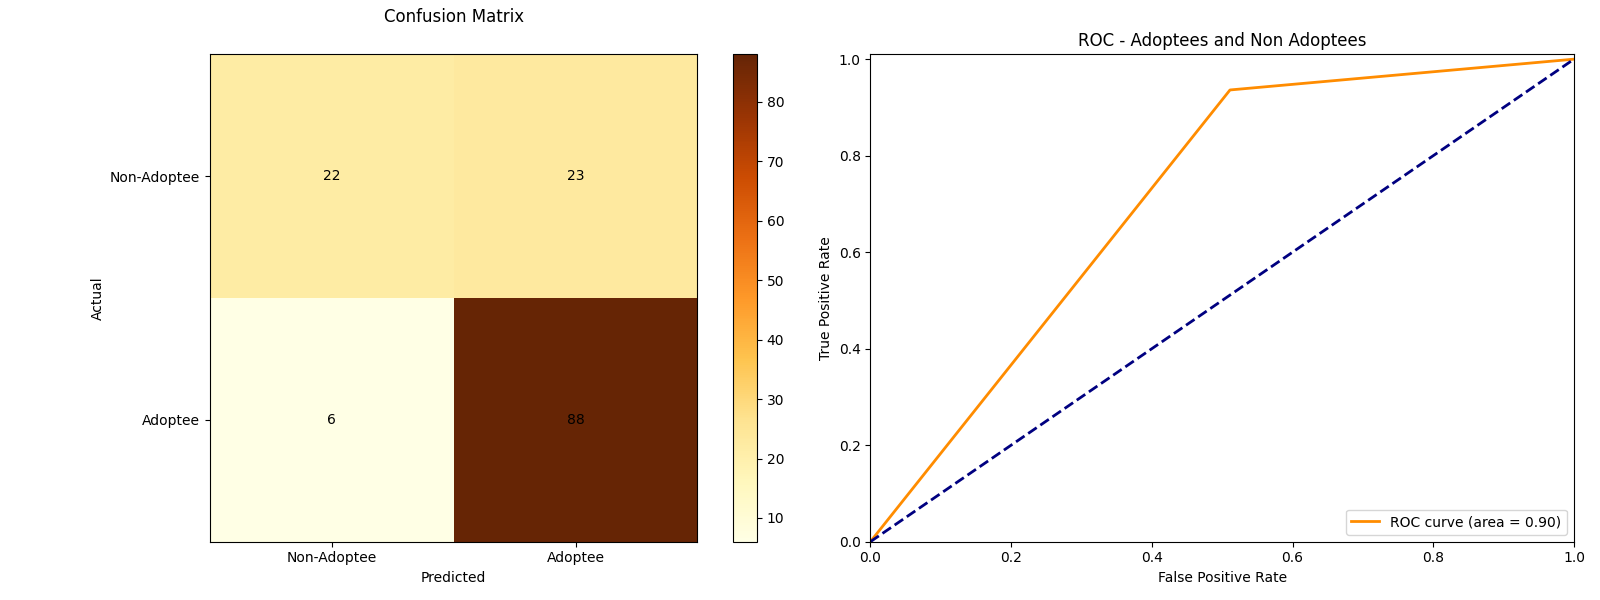

In [229]:
get_plots(rf_preds, rf_auc)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

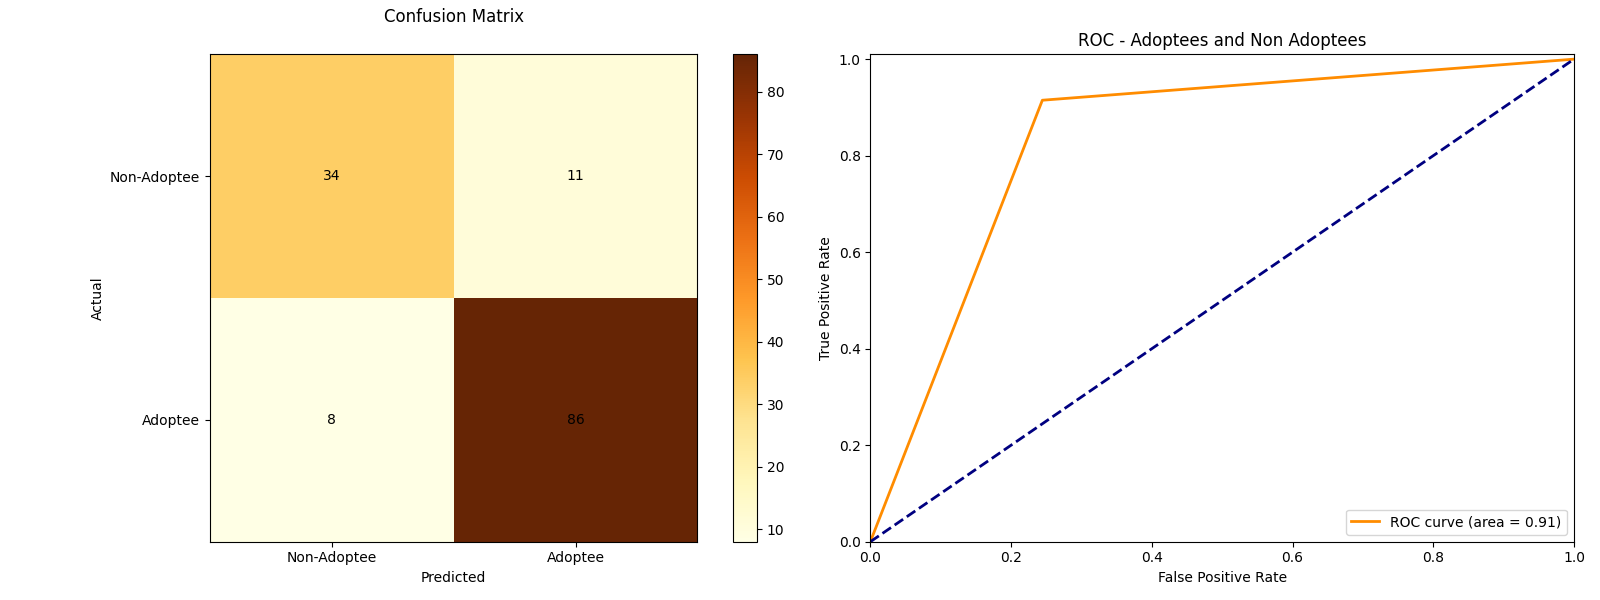

In [230]:
get_plots(lr_preds, lr_auc)
%matplot plt

In [38]:
# Save DataFrame to S3 in Parquet format
feature_df.write.mode("overwrite").parquet("s3://ethan-kozlowski-project/output")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…